In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from construct import *

import collections
import struct

import sys
sys.path.append('../Tianwen/')
import ccsds

In [2]:
crc_table = [0x0000, 0x1021, 0x2042, 0x3063, 0x4084, 0x50a5, 0x60c6, 0x70e7,
    0x8108, 0x9129, 0xa14a, 0xb16b, 0xc18c, 0xd1ad, 0xe1ce, 0xf1ef,
    0x1231, 0x0210, 0x3273, 0x2252, 0x52b5, 0x4294, 0x72f7, 0x62d6,
    0x9339, 0x8318, 0xb37b, 0xa35a, 0xd3bd, 0xc39c, 0xf3ff, 0xe3de,
    0x2462, 0x3443, 0x0420, 0x1401, 0x64e6, 0x74c7, 0x44a4, 0x5485,
    0xa56a, 0xb54b, 0x8528, 0x9509, 0xe5ee, 0xf5cf, 0xc5ac, 0xd58d,
    0x3653, 0x2672, 0x1611, 0x0630, 0x76d7, 0x66f6, 0x5695, 0x46b4,
    0xb75b, 0xa77a, 0x9719, 0x8738, 0xf7df, 0xe7fe, 0xd79d, 0xc7bc,
    0x48c4, 0x58e5, 0x6886, 0x78a7, 0x0840, 0x1861, 0x2802, 0x3823,
    0xc9cc, 0xd9ed, 0xe98e, 0xf9af, 0x8948, 0x9969, 0xa90a, 0xb92b,
    0x5af5, 0x4ad4, 0x7ab7, 0x6a96, 0x1a71, 0x0a50, 0x3a33, 0x2a12,
    0xdbfd, 0xcbdc, 0xfbbf, 0xeb9e, 0x9b79, 0x8b58, 0xbb3b, 0xab1a,
    0x6ca6, 0x7c87, 0x4ce4, 0x5cc5, 0x2c22, 0x3c03, 0x0c60, 0x1c41,
    0xedae, 0xfd8f, 0xcdec, 0xddcd, 0xad2a, 0xbd0b, 0x8d68, 0x9d49,
    0x7e97, 0x6eb6, 0x5ed5, 0x4ef4, 0x3e13, 0x2e32, 0x1e51, 0x0e70,
    0xff9f, 0xefbe, 0xdfdd, 0xcffc, 0xbf1b, 0xaf3a, 0x9f59, 0x8f78,
    0x9188, 0x81a9, 0xb1ca, 0xa1eb, 0xd10c, 0xc12d, 0xf14e, 0xe16f,
    0x1080, 0x00a1, 0x30c2, 0x20e3, 0x5004, 0x4025, 0x7046, 0x6067,
    0x83b9, 0x9398, 0xa3fb, 0xb3da, 0xc33d, 0xd31c, 0xe37f, 0xf35e,
    0x02b1, 0x1290, 0x22f3, 0x32d2, 0x4235, 0x5214, 0x6277, 0x7256,
    0xb5ea, 0xa5cb, 0x95a8, 0x8589, 0xf56e, 0xe54f, 0xd52c, 0xc50d,
    0x34e2, 0x24c3, 0x14a0, 0x0481, 0x7466, 0x6447, 0x5424, 0x4405,
    0xa7db, 0xb7fa, 0x8799, 0x97b8, 0xe75f, 0xf77e, 0xc71d, 0xd73c,
    0x26d3, 0x36f2, 0x0691, 0x16b0, 0x6657, 0x7676, 0x4615, 0x5634,
    0xd94c, 0xc96d, 0xf90e, 0xe92f, 0x99c8, 0x89e9, 0xb98a, 0xa9ab,
    0x5844, 0x4865, 0x7806, 0x6827, 0x18c0, 0x08e1, 0x3882, 0x28a3,
    0xcb7d, 0xdb5c, 0xeb3f, 0xfb1e, 0x8bf9, 0x9bd8, 0xabbb, 0xbb9a,
    0x4a75, 0x5a54, 0x6a37, 0x7a16, 0x0af1, 0x1ad0, 0x2ab3, 0x3a92,
    0xfd2e, 0xed0f, 0xdd6c, 0xcd4d, 0xbdaa, 0xad8b, 0x9de8, 0x8dc9,
    0x7c26, 0x6c07, 0x5c64, 0x4c45, 0x3ca2, 0x2c83, 0x1ce0, 0x0cc1,
    0xef1f, 0xff3e, 0xcf5d, 0xdf7c, 0xaf9b, 0xbfba, 0x8fd9, 0x9ff8,
    0x6e17, 0x7e36, 0x4e55, 0x5e74, 0x2e93, 0x3eb2, 0x0ed1, 0x1ef0]

def crc16_ccitt_false(data):
    crc = 0xffff
    for d in data:
        tbl_idx = ((crc >> 8) ^ d) & 0xff
        crc = (crc_table[tbl_idx] ^ (crc << 8)) & 0xffff
    return crc & 0xffff

AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / ccsds.GreedyBytes
)

def timestamp(p):
    t = struct.unpack('>Q', b'\x00\x00' + p[6:12])[0]
    return np.datetime64('2000-01-01T12:00:00') + np.timedelta64(1, 'ns') * (t * 2**(-16) * 1e9)

## Safe mode

In [3]:
frame_size = 223
frames = np.fromfile('safemode_frames.u8', dtype = 'uint8').reshape((-1,frame_size))

In [4]:
crc_ok = np.array([crc16_ccitt_false(f) for f in frames]) == 0
crc_ok

array([ True,  True,  True, False])

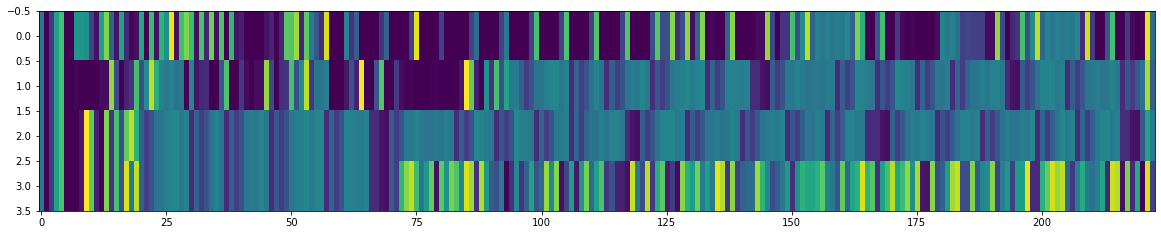

In [5]:
plt.figure(figsize = (20,20), facecolor = 'w')
plt.imshow(frames, aspect = 10)

In [6]:
aos = [AOSFrame.parse(f) for f in frames[:,:-2]] # remove CRC-16
[a.primary_header for a in aos]

[Container(transfer_frame_version_number=1, spacecraft_id=168, virtual_channel_id=0, virtual_channel_frame_count=2856115, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=168, virtual_channel_id=0, virtual_channel_frame_count=2856116, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=168, virtual_channel_id=0, virtual_channel_frame_count=2856117, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=168, virtual_channel_id=0, virtual_channel_frame_count=2856118, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0)]

In [7]:
packets = list(ccsds.extract_space_packets(aos, 168, 0))

In [8]:
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]

In [9]:
packet_headers

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=8, sequence_flags=3, packet_sequence_count_or_name=5687, data_length=39),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=8, sequence_flags=3, packet_sequence_count_or_name=5688, data_length=29),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=8, sequence_flags=3, packet_sequence_count_or_name=5689, data_length=24),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=8, sequence_flags=3, packet_sequence_count_or_name=5690, data_length=34),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=3, packet_sequence_count_or_name=276, data_length=130),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=3, packet_sequence_count_or_name=277, data_length=206),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_fla

In [10]:
[timestamp(p) for p in packets]

[numpy.datetime64('2020-07-30T20:17:01.899688704'),
 numpy.datetime64('2020-07-30T20:17:01.899719296'),
 numpy.datetime64('2020-07-30T20:17:01.900863616'),
 numpy.datetime64('2020-07-30T20:17:02.899047808'),
 numpy.datetime64('2020-07-30T20:25:58.403961216'),
 numpy.datetime64('2020-07-30T20:26:43.904830976'),
 numpy.datetime64('2020-07-30T20:27:29.405853312')]

In [11]:
[p[12:] for h,p in zip(packet_headers, packets) if h.APID == 2047]

[b'N.Abcouwer P.Basa M.Belete E.Benowitz S.Brooks  \r\nJ.Biesiadecki L.Burke D.Byrne S.Chen S.Scandore \r\nJ.Carsten K.Edelberg D.Ga',
 b'N.Abcouwer P.Basa M.Belete E.Benowitz S.Brooks  \r\nJ.Biesiadecki L.Burke D.Byrne S.Chen S.Scandore \r\nJ.Carsten K.Edelberg D.Gaines D.Leang R.Joshi   \r\nR.Haleski A.Harris L.Galdamez S.Lewis T.Litwin  \r\nD',
 b'N.Abcouwer P.Basa M.Belete E.Benowitz S.Brooks  \r\nJ/\xa7\xd2\xe8\xafa\x8a\xc3\x0c\xbf\x83\xcb\xb9u\xf2\xd9$\xe1\x89I>k\x01%y\'Q\x93AW\xd7x\xd1\x0b5\x8f\x11\x85\xcbZ\x93\xb8)A\x17\x16\n\xeak<\xe6*\xa1\xbe\x13-\x06\xd1\xa2\x8f\xc9l\x91i\xf7\xe1\'\xd3/QYZ\xdc\xa6w=Le\x8b"\x82\xa5\x98\x96\xa2\xbesgD\xc1T\x97\xa4\xf2\xa6\xbb#\x94\xb2\xe4\x96\xad\xd4\x82\xdf\x0f\r\xd1;O\x8e\xdd\xe9=<\xceKw}\xd14o\x851\x8c\x90\xf6\x1e\x1f\xa2\xc2\xef\xd7\xe6U)p\x9eh_m\x97\x1b\xec\xe2\x0b\xcd\x1f\x9d\x02']

In [12]:
[p[12:] for h,p in zip(packet_headers, packets) if h.APID == 8]

[b'seqengvP\xcc\xa0\x00\x00C\xb2\x00\x00*\x05\x02\x04\x00\x00\x00\x00\tsfp_15000',
 b'seqengv\x1e\xec*\x00\x00C\xb3\x00\x00*\x06\x01\x04\x00\x00\x00\x00',
 b'seqbg\x00v\x0f\x1c!\x00\x00C\xb8\x00\x00*\x07\x00',
 b'cbm\x00\x00\x00\x10C\x17\xfc\x00\x00C\xbb\x00\x00*\x08\x02\x04\x00\x00\x00\x02\x04\x00\x00\x00\x01']

## 10kbps mode

In [13]:
frame_size = 223 * 5
frames = np.fromfile('mars2020_frames.u8', dtype = 'uint8').reshape((-1,frame_size))
crc_ok = np.array([crc16_ccitt_false(f) for f in frames]) == 0

In [14]:
np.sum(~crc_ok)

4

In [15]:
frames.shape[0]

950

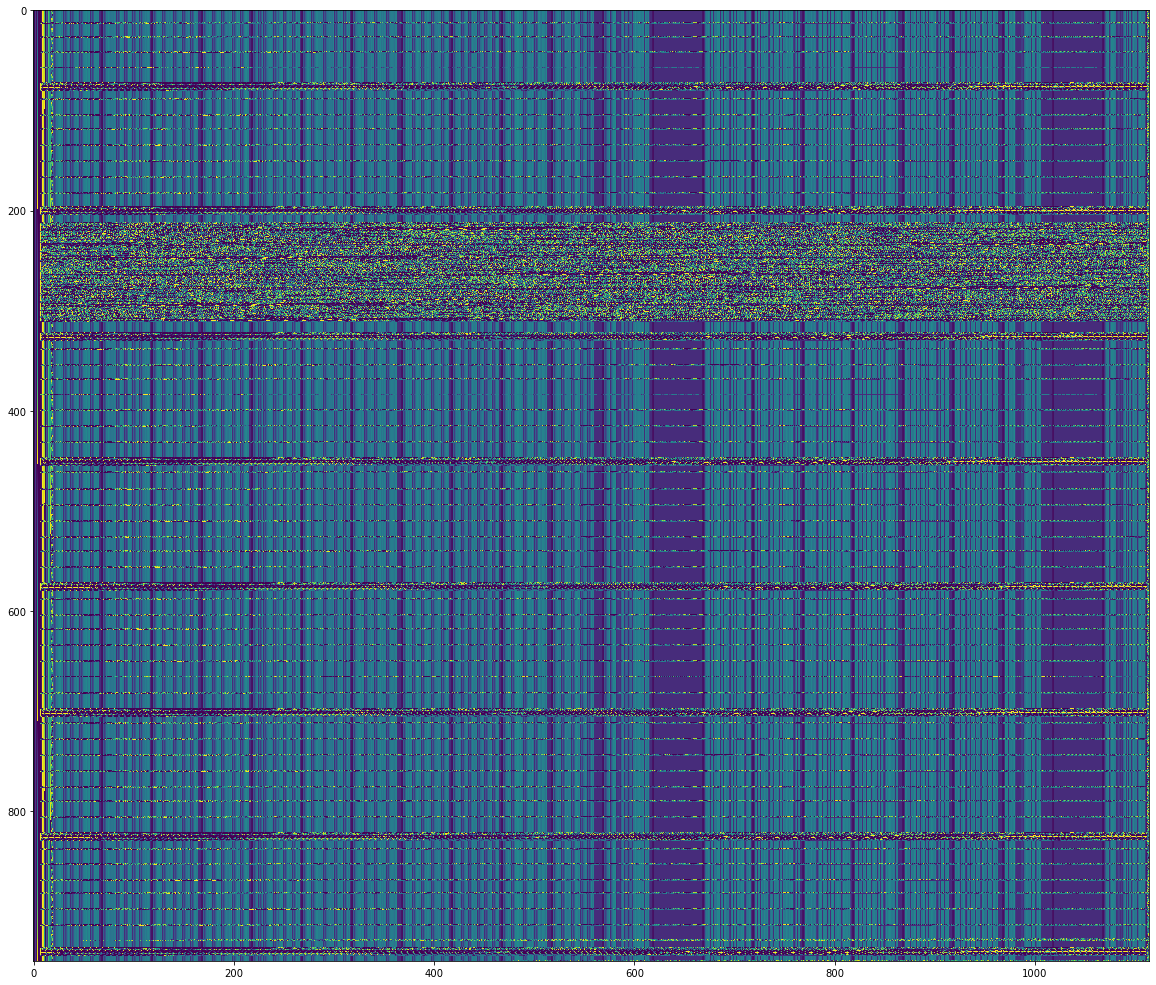

In [16]:
plt.figure(figsize = (20,20), facecolor = 'w')
plt.imshow(frames, aspect = 1)

In [17]:
aos = [AOSFrame.parse(f) for f in frames[crc_ok, :-2]] # Remove CRC-16

In [18]:
[a.primary_header for a in aos[:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=168, virtual_channel_id=0, virtual_channel_frame_count=2950967, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=168, virtual_channel_id=0, virtual_channel_frame_count=2950968, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=168, virtual_channel_id=0, virtual_channel_frame_count=2950969, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=168, virtual_channel_id=0, virtual_channel_frame_count=2950970, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=168, virtual_channel_id=0, virtual_channel_frame_count=2950971, replay_flag=False, vc_frame_co

In [19]:
{a.primary_header.virtual_channel_id for a in aos}

{0}

In [20]:
fc = np.array([a.primary_header.virtual_channel_frame_count for a in aos])

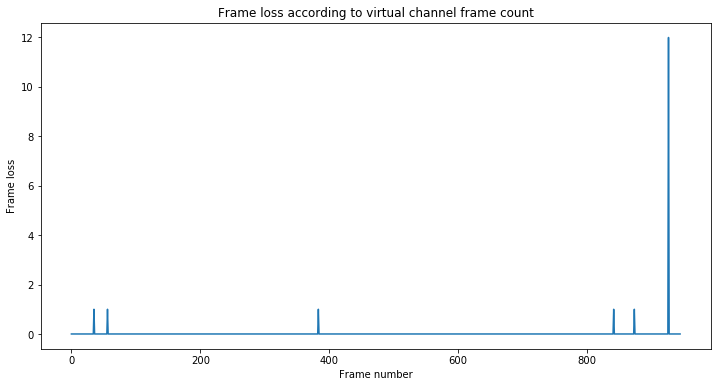

In [21]:
plt.figure(figsize = (12,6))
plt.plot(np.diff(fc)-1)
plt.title('Frame loss according to virtual channel frame count')
plt.ylabel('Frame loss')
plt.xlabel('Frame number');

In [22]:
packets = list(ccsds.extract_space_packets(aos, 168, 0))

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 168 VC 0] Broken stream. Last frame count 2951002, current frame count 2951004
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 168 VC 0] Broken stream. Last frame count 2951024, current frame count 2951026
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 168 VC 0] Broken stream. Last frame count 2951352, current frame count 2951354
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

In [23]:
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]
apid = np.array([h.APID for h in packet_headers])
timestamps = np.array([timestamp(p) for p in packets])

In [24]:
apids = collections.Counter([p.APID for p in packet_headers])
apids

Counter({2047: 741, 9: 58, 247: 14})

Text(0.5, 0, 'Space Packet number')

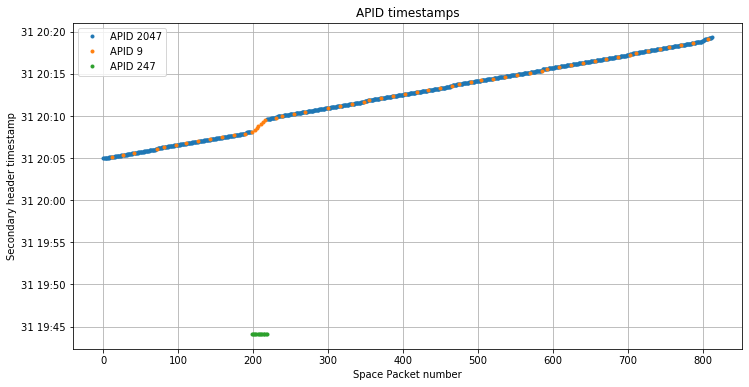

In [25]:
plt.figure(figsize = (12,6), facecolor = 'w')
for a in apids.keys():
    plt.plot(np.arange(timestamps.size)[apid == a], timestamps[apid == a],
            '.', label = f'APID {a}')
plt.legend()
plt.grid()
plt.title('APID timestamps')
plt.ylabel('Secondary header timestamp')
plt.xlabel('Space Packet number')

In [26]:
by_apid = {apid : [p for h,p in zip(packet_headers, packets) if h.APID == apid]
           for apid in apids}

In [27]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in by_apid[9][:5]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=9, sequence_flags=3, packet_sequence_count_or_name=3511, data_length=1243),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=9, sequence_flags=3, packet_sequence_count_or_name=3512, data_length=1242),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=9, sequence_flags=3, packet_sequence_count_or_name=3513, data_length=1369),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=9, sequence_flags=3, packet_sequence_count_or_name=3515, data_length=8957),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=9, sequence_flags=3, packet_sequence_count_or_name=3516, data_length=1240)]

In [28]:
def heuristic_chunk(b):
    j = 0
    sizes = [8,4,2]
    jumps = [32, 64, 256, 512]
    also_allowed = [(0x5b2, 0x8b3), (0xbc3, 0xe1b), (0x101d, 0x18bf), (0x18bf, 0x1bf7),
                   (0x1bfa, 0x2093), (0x20fb, 0x29b9)]
    while True:
        tag = struct.unpack('>H', b[j:j+2])[0]
        for jump, size in [(j,s) for j in jumps for s in sizes]:
            next_tag = struct.unpack('>H', b[j+2+size:j+4+size])[0]
            if 0 < next_tag - tag < jump or (tag,next_tag) in also_allowed:
                yield tag, b[j+2:j+2+size]
                j = j+2+size
                break
        else:
            break

In [29]:
chunks = [(timestamp(p),) + a for p in by_apid[9] for a in list(heuristic_chunk(p[12:]))]

In [30]:
[(hex(a[1]), a[2].hex()) for a in chunks[:20]]

[('0x27a', '3fc4b0a55e22a0db'),
 ('0x27d', '00000000'),
 ('0x27e', '00000000'),
 ('0x27f', '00007724'),
 ('0x280', '00000000'),
 ('0x281', '00000000'),
 ('0x282', '00000000'),
 ('0x283', '00007724'),
 ('0x284', '00000000'),
 ('0x28f', '408ab373b6b8cd2b'),
 ('0x290', 'c091fa089c0d1d06'),
 ('0x291', '408357185e6382d7'),
 ('0x293', '3fe1bce47c2f3820'),
 ('0x294', '3f9348edcf3694cd'),
 ('0x295', '3fdded1d8f24a95f'),
 ('0x296', '3fe60674b3ad1105'),
 ('0x298', '3f67bfec206e3db7'),
 ('0x299', '3f56b176a0167c2d'),
 ('0x29a', '3fcb60385419d569'),
 ('0x29c', '3e9dc39d5f82e48a')]

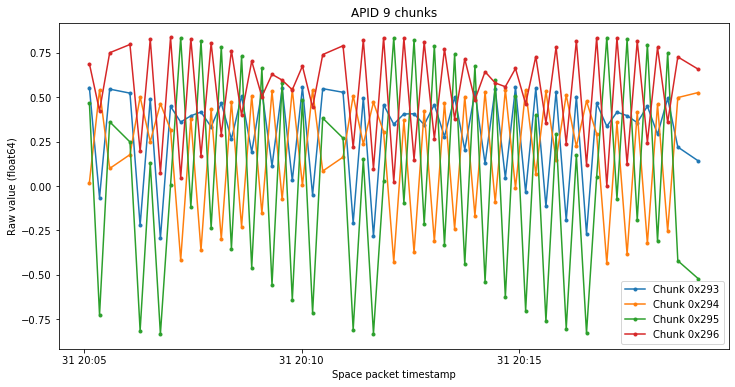

In [31]:
plt.figure(figsize = (12,6), facecolor = 'w')
for i in range(0x293, 0x297):
    sc = [c for c in chunks if c[1] == i]
    plt.plot([c[0] for c in sc], [struct.unpack('>d', c[2])[0] for c in sc], '.-',
            label = f'Chunk {hex(i)}')
plt.legend()
plt.ylabel('Raw value (float64)')
plt.xlabel('Space packet timestamp')
plt.title('APID 9 chunks');

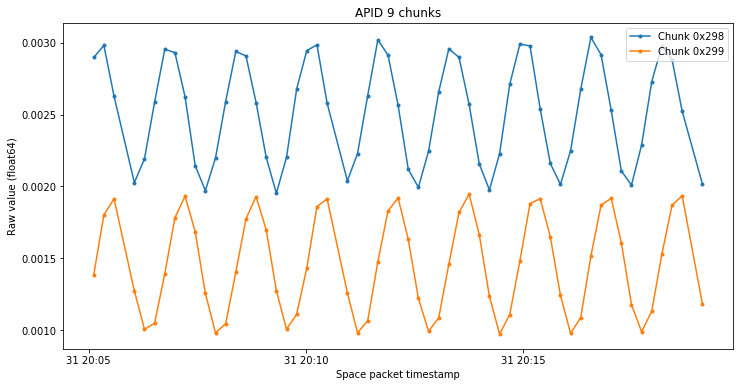

In [32]:
plt.figure(figsize = (12,6), facecolor = 'w')
for i in range(0x298, 0x29a):
    sc = [c for c in chunks if c[1] == i]
    plt.plot([c[0] for c in sc], [struct.unpack('>d', c[2])[0] for c in sc], '.-',
             label = f'Chunk {hex(i)}')
plt.legend()
plt.ylabel('Raw value (float64)')
plt.xlabel('Space packet timestamp')
plt.title('APID 9 chunks');

In [33]:
[p[12:64].hex() for p in by_apid[9][:10]]

['027a3fc4b0a55e22a0db027d00000000027e00000000027f00007724028000000000028100000000028200000000028300007724',
 '027a3fd487d0f660cd9b027d00000000027e00000000027f00007724028000000000028100000000028200000000028300007724',
 '027a3fd0d90f1448995f027d00000000027e00000000027f00007724028000000000028100000000028200000000028300007724',
 '01f50000000101f60000000001f70000000101f80000000001f90000000101fa0000000001fb0000000101fc0000000001fd0000',
 '027a3fce8f20f40f8c44027d00000000027e00000000027f00007724028000000000028100000000028200000000028300007724',
 '027a3fe1b4b7d417ae74027d00000000027e00000000027f00007724028000000000028100000000028200000000028300007724',
 '027a3fde55f7e8aff142027d00000000027e00000000027f00007724028000000000028100000000028200000000028300007724',
 '027a3fc8294de5246b73027d00000000027e00000000027f00007724028000000000028100000000028200000000028300007724',
 '027a3fd0a779c031d70c027d00000000027e00000000027f00007724028000000000028100000000028200000000028300007724',
 '027a3fd9871585b54

In [34]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in by_apid[247][:5]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=247, sequence_flags=3, packet_sequence_count_or_name=0, data_length=104),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=247, sequence_flags=3, packet_sequence_count_or_name=1, data_length=9325),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=247, sequence_flags=3, packet_sequence_count_or_name=2, data_length=10064),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=247, sequence_flags=3, packet_sequence_count_or_name=3, data_length=10232),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=247, sequence_flags=3, packet_sequence_count_or_name=4, data_length=10156)]

In [35]:
[p[12:64].hex() for p in by_apid[247][:10]]

['0016caa69607460000000000fd000000000000240f0bffff000005000100280004000a0000000000000000000000000000000000',
 '01000000000a420005e126b68b1e0000000005d7027a3fd463a28c6052a3027d00000000027e00000000027f0000772402800000',
 '01002444000a4200066a26b68b56000000000660027a3fd830a1cac6d32e027d00000000027e00000000027f0000772402800000',
 '01004b5b000a42000fb526b68baa000000000fab019100000007019200000000019300000000025a3ff4f1a9fbe76c8b025b0000',
 '01007322000a4200060726b68bf00000000005fd027a3fd09c49c9991db0027d00000000027e00000000027f0000772402800000',
 '01009a9d000a4200063426b68c3600000000062a027a3fd9f0b1465c8512027d00000000027e00000000027f0000772402800000',
 '0100bfbd000a4200102426b68c8a00000000101a019100000007019200000000019300000000025a3ff4f1a9fbe76c8b025b0000',
 '0100e2f1000a4200063326b68cc2000000000629027a3fd48df4a3a9798d027d00000000027e00000000027f0000772402800000',
 '0100fd28000a4200103726b68cfa00000000102d019100000007019200000000019300000000025a3ff4f1a9fbe76c8b025b0000',
 '01011fd7000a42000

In [36]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in by_apid[2047][:5]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12456, data_length=1098),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12457, data_length=1098),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12458, data_length=1098),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12459, data_length=1098),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12460, data_length=1098)]

In [37]:
print(str(by_apid[2047][0][12:], encoding = 'ascii'))

N.Abcouwer P.Basa M.Belete E.Benowitz S.Brooks  
J.Biesiadecki L.Burke D.Byrne S.Chen S.Scandore 
J.Carsten K.Edelberg D.Gaines D.Leang R.Joshi   
R.Haleski A.Harris L.Galdamez S.Lewis T.Litwin  
D.Lam Q.Ho M.Maimone M.McHenry D.Morgan S.Myint 
B.Martin P.Partikian G.Rabideau P.Romano R.Tsao 
M.Schoppers A.Shearer R.Srisamang C.Williams    
L.Stewart O.Toupet I.Trettel I.Uchenik V.Verma  
P.Vieira E.Wang B.Wright G.Yang B.Cichy C.Pong  
G.Reeves M.Tuszynski J.Casoliva P.Brugarolas    
Z.Rahman G.Griffin T.Fouser M.Wang P.Kwan       
A.Baez Harry *** The MSL FSW development team.  
                                                
 There is beauty in space, it is orderly. There 
 is no weather, and there is regularity. It is  
 predictable. Just look at our little Explorer; 
 you can set your clock by it. Everything in    
 space obeys the laws of physics. If you know   
 these laws, and obey them, space will treat    
 you kindly.     -- Wernher von Braun           
                    